In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, schedules
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Preparation - MNIST

In [21]:
# Loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Train images: {train.shape[0]}\nTest images: {test.shape[0]}")

Train images: 42000
Test images: 28000


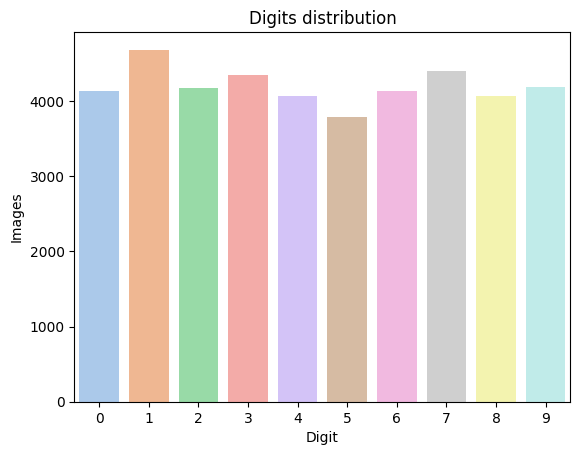

In [22]:
Y_train = train["label"]
X_train = train.drop("label", axis=1)

# Digits distribution
sns.countplot(x=Y_train, hue=Y_train, palette=("pastel"), legend=False)
plt.xlabel("Digit")
plt.ylabel("Images")
plt.title("Digits distribution")
plt.show()

In [23]:
# Checking nulls
print("Train Nulls:", X_train.isnull().values.sum())
print("Test Nulls:", test.isnull().values.sum())

Train Nulls: 0
Test Nulls: 0


In [24]:
# Normalization
X_train = X_train / 255.0
test = test / 255.0

In [25]:
# Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [26]:
# Label Encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
# Split Training and Validation Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

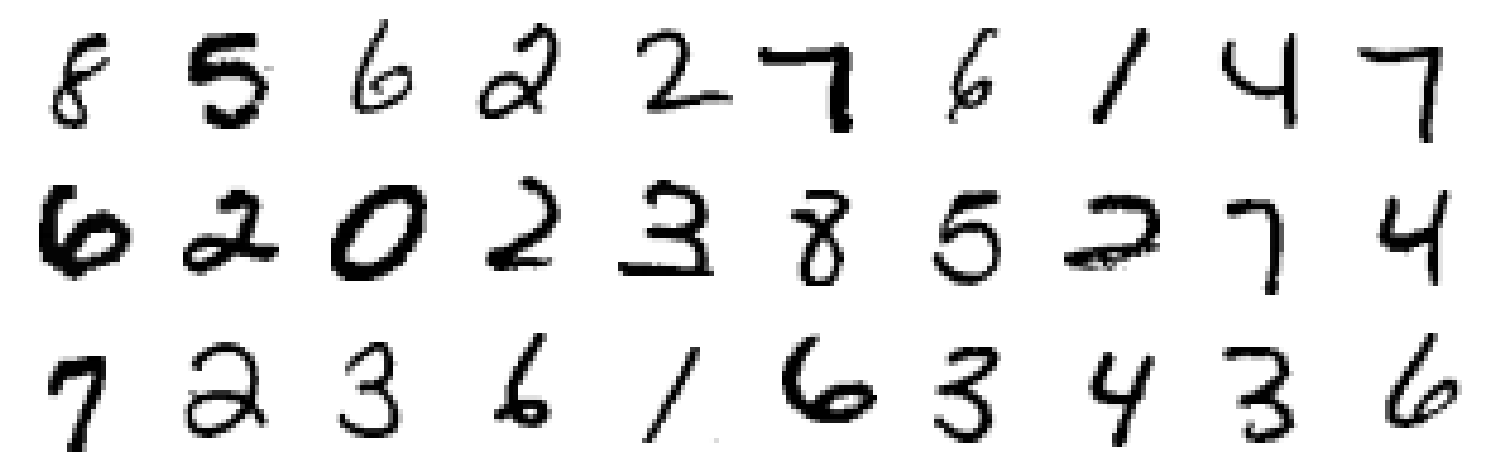

In [28]:
# Plotting example digits
plt.figure(figsize=(15,5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap="binary")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
# Data generation for data augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1,
                            shear_range=0.1, horizontal_flip=False, vertical_flip=False, fill_mode='constant', cval=0)

### CNN

In [ ]:
reg = l2(1e-4)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg, input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(Conv2D(32, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(Conv2D(64, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(Conv2D(256, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(256, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))

model.add(Dense(10, activation="softmax"))

In [ ]:
epochs = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size
total_steps = epochs * steps_per_epoch

train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

# es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True) 
# rlr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor = 0.5, min_lr = 1e-6)
mc_loss = ModelCheckpoint('best_model_loss.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')
callbacks = [mc_loss]

lr_schedule = tf.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=total_steps, alpha=0.0)
optimizer = Adam(learning_rate=lr_schedule)
loss = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        288       
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9216      
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 28, 28, 32)       

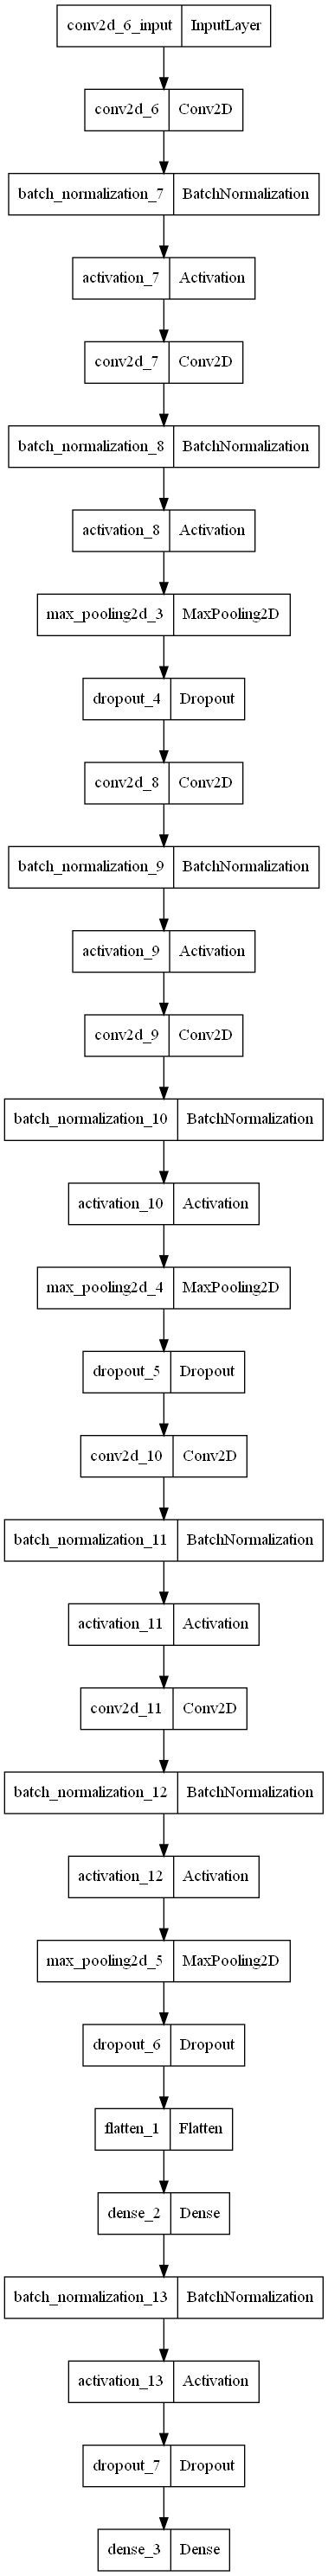

In [32]:
plot_model(model)

In [33]:
learning_hist = model.fit(train_gen, epochs = epochs, validation_data = (X_val, Y_val), callbacks=callbacks)

Epoch 1/100
591/591 [==============================] - 10s 15ms/step - loss: 1.0305 - accuracy: 0.8935 - val_loss: 0.7855 - val_accuracy: 0.9836
Epoch 2/100
591/591 [==============================] - 15s 25ms/step - loss: 0.7953 - accuracy: 0.9754 - val_loss: 0.7247 - val_accuracy: 0.9888
Epoch 3/100
591/591 [==============================] - 16s 27ms/step - loss: 0.7330 - accuracy: 0.9823 - val_loss: 0.6744 - val_accuracy: 0.9921
Epoch 4/100
591/591 [==============================] - 15s 25ms/step - loss: 0.6893 - accuracy: 0.9849 - val_loss: 0.6410 - val_accuracy: 0.9924
Epoch 5/100
591/591 [==============================] - 15s 25ms/step - loss: 0.6553 - accuracy: 0.9879 - val_loss: 0.6187 - val_accuracy: 0.9929
Epoch 6/100
591/591 [==============================] - 16s 27ms/step - loss: 0.6349 - accuracy: 0.9880 - val_loss: 0.6003 - val_accuracy: 0.9924
Epoch 7/100
591/591 [==============================] - 17s 28ms/step - loss: 0.6215 - accuracy: 0.9877 - val_loss: 0.5878 - val_ac

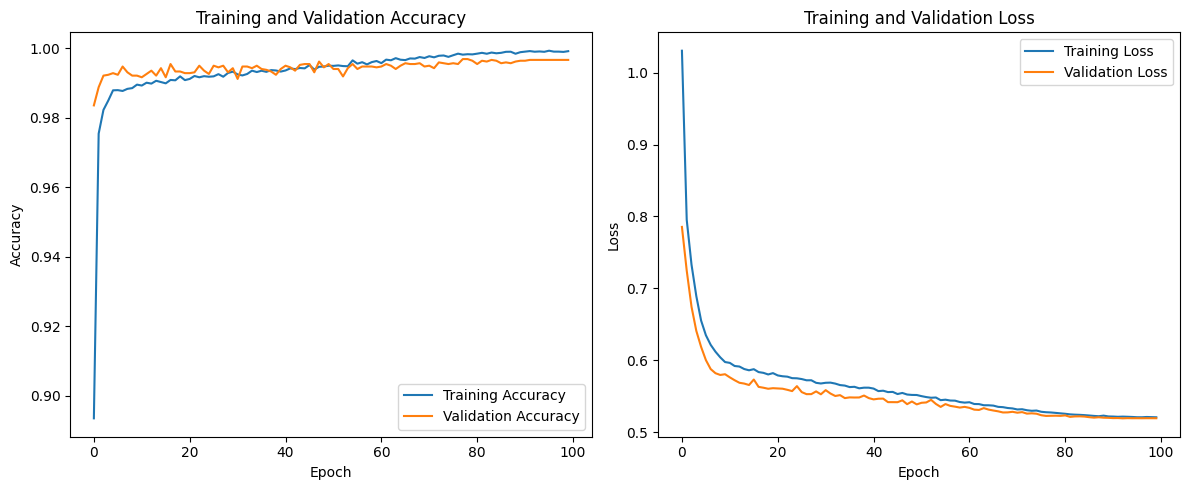

In [34]:
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(learning_hist.history['accuracy'], label='Training Accuracy')
plt.plot(learning_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(learning_hist.history['loss'], label='Training Loss')
plt.plot(learning_hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Función para Test Time Augmentation
def tta_prediction(model, X_test, loops=5):
    probs = np.zeros((len(X_test), 10))
    
    print(f"Realizando TTA ({loops} pasadas)...")
    for i in range(loops):
        print(f"Pasada {i+1}/{loops}...")
        test_gen = datagen.flow(X_test, batch_size=batch_size, shuffle=False)
        probs += model.predict(test_gen)
        
    probs /= loops
    return probs

In [ ]:
print(f"Cargando mejor modelo por test loss")
model = load_model('best_model_loss.h5')

preds_tta = tta_prediction(model, test, loops=10)
preds_tta = np.argmax(preds_tta, axis=1)
preds_tta = pd.Series(preds_tta, name="Label")

print(f"Guardando predicciones...")
submission_tta = pd.concat([pd.Series(range(1, len(preds_tta) + 1), name="ImageId"), preds_tta], axis=1)
submission_tta.to_csv("CNN_keras_submission_loss.csv", index=False)

Cargando mejor modelo por test loss
Realizando TTA (10 pasadas)...
Pasada 1/10...
438/438 [==============================] - 5s 11ms/step
Pasada 2/10...
438/438 [==============================] - 5s 11ms/step
Pasada 3/10...
438/438 [==============================] - 5s 11ms/step
Pasada 4/10...
438/438 [==============================] - 5s 11ms/step
Pasada 5/10...
438/438 [==============================] - 5s 11ms/step
Pasada 6/10...
438/438 [==============================] - 5s 11ms/step
Pasada 7/10...
438/438 [==============================] - 5s 11ms/step
Pasada 8/10...
438/438 [==============================] - 11s 26ms/step
Pasada 9/10...
438/438 [==============================] - 6s 13ms/step
Pasada 10/10...
438/438 [==============================] - 5s 11ms/step
Guardando predicciones...


### Conclusions and Insights